# 批量归一化实现

In [2]:
import torch as tor
from torch import nn as tor_nn
from d2l import torch as d2l_tor

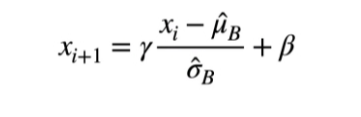

In [3]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    '''
    变量说明：
    X          :输入层(x_i那个玩意)
    gamma      :γ符号，前面的线性系数系数
    beta       :β符号，后面的常数系数
    moving_mean:全局均值
    moving_var :全局方差
    eps        :一个小扰动，防止得出的数字是0
    momentum   :一个合适的变化速度
    '''
    if not tor.is_grad_enabled():
        # 表明没有在进行训练，而是在进行推理
        X_hat = (X - moving_mean) / tor.sqrt(moving_var + eps)
    else:
        # 训练状态
        assert len(X.shape) in (2, 4) # 规定两种制式，这里实现的是最为简单的归一化，所以基本上就是全连接
        if(len(X.shape) == 2):
            # 全连接2层双层状态
            mean = X.mean(dim = 0) # 规定位置距离，不变维度
            var  = ((X - mean)**2).mean(dim=0)
        else:
            # 卷积状态
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var  = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / tor.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean # 跟新数据的一种最为朴素的方法相当于是做了一个二阶系统
        moving_var = momentum * moving_var + (1.0 - momentum) * var # 跟新数据的一种最为朴素的方法相当于是做了一个二阶系统
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

创建一个批量归一化层

In [4]:
class BatchNorm(tor_nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = tor_nn.Parameter(tor.ones(shape)) # 要学习的参数γ
        self.beta = tor_nn.Parameter(tor.zeros(shape)) # 要学习的参数β
        self.moving_mean = tor.zeros(shape)
        self.moving_var = tor.ones(shape)   # 由于这里是一个二阶系统的初响应值，而且这个系统明显是一个以之后的状态进行计算的函数，所以他应该是一个零输入响应

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

用于LeNet测试一下

In [7]:
net = tor_nn.Sequential(
    tor_nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), tor_nn.Sigmoid(),
    tor_nn.AvgPool2d(kernel_size=2, stride=2),
    tor_nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), tor_nn.Sigmoid(),
    tor_nn.AvgPool2d(kernel_size=2, stride=2), tor_nn.Flatten(),
    tor_nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), tor_nn.Sigmoid(),
    tor_nn.Linear(120, 84), BatchNorm(84, num_dims=2), tor_nn.Sigmoid(),
    tor_nn.Linear(84, 10))

训练一下

loss 0.271, train acc 0.900, test acc 0.748
13338.8 examples/sec on cuda:0


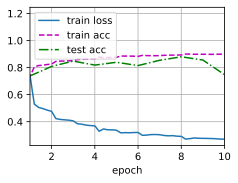

In [8]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l_tor.load_data_fashion_mnist(batch_size)
d2l_tor.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l_tor.try_gpu())

看一下γ系数和β系数

In [9]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([0.3834, 2.1146, 3.4437, 2.7378, 4.2421, 1.6545], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-0.5118, -1.7914,  1.2447, -3.0836, -2.5968, -1.7573], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

这边看一下我们直接调包是一个什么样的策略

In [11]:
net = tor_nn.Sequential(
    tor_nn.Conv2d(1, 6, kernel_size=5), tor_nn.BatchNorm2d(6), tor_nn.Sigmoid(),
    tor_nn.AvgPool2d(kernel_size=2, stride=2),
    tor_nn.Conv2d(6, 16, kernel_size=5), tor_nn.BatchNorm2d(16), tor_nn.Sigmoid(),
    tor_nn.AvgPool2d(kernel_size=2, stride=2), tor_nn.Flatten(),
    tor_nn.Linear(256, 120), tor_nn.BatchNorm1d(120), tor_nn.Sigmoid(),
    tor_nn.Linear(120, 84), tor_nn.BatchNorm1d(84), tor_nn.Sigmoid(),
    tor_nn.Linear(84, 10))

注意一下这里直接调包的使用方法：我们使用的是nn.moudle中的BatchNorm**x**d函数，要表明的只有一个点，就是我们的输出通道数

训练一下

loss 0.259, train acc 0.904, test acc 0.878
20190.7 examples/sec on cuda:0


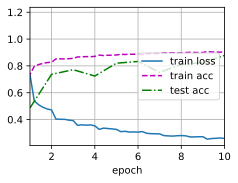

In [13]:
d2l_tor.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l_tor.try_gpu())